In [1]:
# default_exp calib

# Import

In [2]:
# export
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

from camera_calib_python.control_refine import CheckerRefiner
from camera_calib_python.modules import (CamSF, Heikkila97Distortion, Inverse,
                                         Normalize, Rigid)
from camera_calib_python.utils import *

In [3]:
import re
from pathlib import Path

import pandas as pd
from IPython.core.debugger import set_trace

from camera_calib_python.cb_geom import CbGeom, CpCSRGrid, FmCFPGrid
from camera_calib_python.control_refine import OpenCVCheckerRefiner
from camera_calib_python.fiducial_detect import DotVisionCheckerDLDetector
from camera_calib_python.image import File16bitImg

# Utility

Note that principle point initial guess, from my experience, is very unstable, so just set it to the middle of the image.

In [4]:
# export
def init_intrin(Hs, sz):
    yo, xo = (np.array(sz)-1)/2
    po_inv = np.array([[1, 0, -xo],
                       [0, 1, -yo],
                       [0, 0,   1]])
    A, b = [], []
    for H in Hs:
        H_bar = po_inv@H
        v1, v2 = H_bar[:,0], H_bar[:,1]
        v3, v4 = v1+v2, v1-v2
        v1, v2, v3, v4 = unitize(np.stack([v1, v2, v3, v4]))
        A.append(np.array([v1[0]*v2[0]+v1[1]*v2[1], v3[0]*v4[0]+v3[1]*v4[1]]))
        b.append(np.array([-v1[2]*v2[2], -v3[2]*v4[2]]))
    A, b = map(np.concatenate, [A, b])
    alpha = np.sqrt(np.dot(b,A)/np.dot(b,b))
    return np.array([[alpha,     0, xo],
                     [    0, alpha, yo],
                     [    0,     0,  1]])

In [5]:
# export
def init_extrin(H, A):
    H_bar = np.linalg.inv(A)@H
    lambdas = np.linalg.norm(H_bar, axis=0)
    r1, r2 = [H_bar[:,idx]/lambdas[idx] for idx in range(2)]
    r3 = np.cross(r1, r2)
    R = approx_R(np.c_[r1,r2,r3])
    t = H_bar[:,2]/np.mean(lambdas[0:2])
    return R, t

In [6]:
# export
def SSE(x1, x2): return ((x1-x2)**2).sum()

In [7]:
# export
def w2p_loss(w2ps, ps_c_w, pss_c_p, loss):
    ls = []
    for w2p, ps_c_p in zip(w2ps, pss_c_p):
        idx = torch.all(torch.isfinite(ps_c_p), dim=1)
        ls.append(loss(w2p(ps_c_w[idx]), ps_c_p[idx]))
    return sum(ls)

In [8]:
# export
def lbfgs_optimize(f_get_params, f_get_loss, cutoff_it, cutoff_norm):
    def _cat_params(): return torch.cat([p.view(-1) for p in f_get_params()])    
    optim = torch.optim.LBFGS(f_get_params())
    params_prev = _cat_params()
    for it in range(cutoff_it):
        def _closure():
            optim.zero_grad()
            l = f_get_loss()
            l.backward()
            return l
        optim.step(_closure)
        params = _cat_params()
        norm = torch.norm(params-params_prev)
        print(f' - Iteration: {it:03d} - Norm: {norm.item():10.5f} - Loss: {f_get_loss().item():10.5f}')
        if norm < cutoff_norm: break
        params_prev = params

Node stuff is for coordinate graph (from Bo Li's paper) and initial guess for multiple cameras

In [9]:
# export
class Node:
    def __init__(self, label):
        self.label = label

    def __repr__(self):
        return f'{self.__class__.__name__}({self.label})'

In [10]:
# export
class CamNode(Node):
    def __init__(self, label, cam, distort):
        super().__init__(label)
        self.cam, self.distort = cam, distort

In [11]:
# export
class CbNode(Node):
    def __init__(self, label):
        super().__init__(label)

In [12]:
# export
def draw_bipartite(G, nodes1, nodes2, ax=None):
    for node in nodes1[1:]: assert_allclose(type(nodes1[0]), type(node))
    for node in nodes2[1:]: assert_allclose(type(nodes2[0]), type(node))
        
    if ax == None: _, ax = plt.subplots(1, 1, figsize=(10,10))        
    def _get_p(nodes, x): return {node: (x,y) for node,y in zip(nodes, np.linspace(0, 1, len(nodes)))}
    nx.draw(G, 
            node_color=['g' if isinstance(node, type(nodes1[0])) else 'r' for node in G], 
            pos={**_get_p(nodes1, 0), 
                 **_get_p(nodes2, 1)}, 
            with_labels=True,
            ax=ax)
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    ax.invert_yaxis()

# Single Calibration

This will calibrate a single camera. Some things:
* rigid transforms convert from calibration board coordinates => camera coordinates.

In [13]:
# export
def single_calib(imgs, 
                 cb_geom, 
                 detector, 
                 refiner,
                 Cam=CamSF,
                 Distortion=lambda:Heikkila97Distortion(*torch.zeros(4, dtype=torch.double)),
                 loss=SSE,
                 cutoff_it=500,
                 cutoff_norm=1e-6):
    # Get calibration board world coordinates
    ps_f_w, ps_c_w, bs_c_w = cb_geom.ps_f, cb_geom.ps_c, cb_geom.bs_c
    
    # Get initial homographies via fiducial markers
    Hs = [homography(ps_f_w, detector(img.array_gs)) for img in imgs]

    # Refine control points    
    pss_c_p = []
    for img, H in zip(imgs, Hs):
        print(f'Refining control points for: {img.name}...')
        ps_c_p = pmm(ps_c_w, H, aug=True) # This guess should be updated for circle control points
        bs_c_p = [pmm(b_c_w, H, aug=True) for b_c_w in bs_c_w]
        pss_c_p.append(refiner(img.array_gs, ps_c_p, bs_c_p))

    # Update homographies with refined control points; should be updated for circle control points
    Hs = [homography(ps_c_w, ps_c_p) for ps_c_p in pss_c_p]

    # Get initial guesses; distortion assumed to be zero
    A = init_intrin(Hs, imgs[0].size)
    Rs, ts = zip(*[init_extrin(H, A) for H in Hs])
            
    # Format control points
    ps_c_w = torch.DoubleTensor(np.c_[ps_c_w, np.zeros(len(ps_c_w))]) # 3rd dimension is zero
    pss_c_p = [torch.DoubleTensor(ps_c_p) for ps_c_p in pss_c_p]
    
    # Initialize modules
    cam = Cam(torch.DoubleTensor(A))
    distort = Distortion()
    rigids = [Rigid(*map(torch.DoubleTensor, [R,t])) for R,t in zip(Rs,ts)]
    if isinstance(refiner, CheckerRefiner):
        w2ps = [torch.nn.Sequential(rigid,  Normalize(), distort, cam) for rigid in rigids]
    else:
        raise RuntimeError(f'Dont know how to handle: {type(refiner)}')
        
    # Optimize parameters
    print(f'Refining single parameters...')
    lbfgs_optimize(lambda: sum([list(m.parameters()) for m in [cam, distort]+rigids], []), 
                   lambda: w2p_loss(w2ps, ps_c_w, pss_c_p, loss), 
                   cutoff_it, 
                   cutoff_norm)
        
    return (cam, distort, rigids, 
            (torch2np(tuple(pss_c_p)), 
             torch2np(tuple([w2p(ps_c_w) for w2p in w2ps]))))

# Multi Calibration

This will calibrate multiple cameras. Some things:
* rigid transforms convert from camera/cb coordinates => "root" coordinates
* root coordinates are set to the first camera's coordinates, so the first camera's coordinates => "root" coordinates are just the identity transform
* this might seem a smidge unnecessary, but it makes the math/code more general/elegant/simpler

In [14]:
# export 
def calib_multi(imgs, 
                cb_geom, 
                detector, 
                refiner,
                Cam=CamSF,
                Distortion=lambda:Heikkila97Distortion(*torch.zeros(4, dtype=torch.double)),
                loss=SSE,
                cutoff_it=500,
                cutoff_norm=1e-6):
    # Get calibration board world coordinates
    ps_c_w = cb_geom.ps_c
    
    # Get sorted unique indices of cams and cbs; np.unique will sort according to docs
    idxs_cam = np.unique([img.idx_cam for img in imgs])
    idxs_cb  = np.unique([img.idx_cb  for img in imgs])
    assert_allclose(idxs_cam, np.arange(len(idxs_cam)))
    assert_allclose(idxs_cb,  np.arange(len(idxs_cb)))
         
    # Form coordinate graph (from Bo Li's camera calibration paper)    
    G = nx.DiGraph()
    nodes_cb  = [CbNode(idx_cb) for idx_cb in idxs_cb]
    nodes_cam = []
    for idx_cam in idxs_cam:
        imgs_cam = [img for img in imgs if img.idx_cam == idx_cam]
        cam, distort, rigids, (pss_c_p, _) = single_calib(imgs_cam,
                                                          cb_geom,
                                                          detector,
                                                          refiner,
                                                          Cam,
                                                          Distortion,
                                                          loss,
                                                          cutoff_it,
                                                          cutoff_norm)
        for img_cam, ps_c_p in zip(imgs_cam, pss_c_p): img_cam.ps_c_p = ps_c_p
        node_cam = CamNode(idx_cam, cam, distort)
        for img_cam, rigid in zip(imgs_cam, rigids):
            node_cb = nodes_cb[img_cam.idx_cb]
            G.add_edge(node_cb,  node_cam, rigid=rigid)
            G.add_edge(node_cam, node_cb,  rigid=Inverse(rigid))
        nodes_cam.append(node_cam)
        
    # Do BFS and compute initial affines along the way
    nodes_cam[0].M = torch.eye(4, dtype=torch.double)
    for (node_prnt, node_chld) in nx.bfs_edges(G, nodes_cam[0]):
        node_chld.M = node_prnt.M@G.get_edge_data(node_chld, node_prnt)['rigid'].get_param()
    
    # Format control points 
    ps_c_w = torch.DoubleTensor(np.c_[ps_c_w, np.zeros(len(ps_c_w))]) # 3rd dimension is zero
    pss_c_p = [torch.DoubleTensor(img.ps_c_p) for img in imgs]
    
    # Initialize modules
    cams = [node_cam.cam for node_cam in nodes_cam]
    distorts = [node_cam.distort for node_cam in nodes_cam]
    rigids_cb  = [Rigid(*M2Rt(node_cb.M))  for node_cb  in nodes_cb]
    rigids_cam = [Rigid(*M2Rt(node_cam.M)) for node_cam in nodes_cam]
    if isinstance(refiner, CheckerRefiner):
        w2ps = [torch.nn.Sequential(rigids_cb[img.idx_cb],
                                    Inverse(rigids_cam[img.idx_cam]),
                                    Normalize(), 
                                    distorts[img.idx_cam], 
                                    cams[img.idx_cam]) for img in imgs]
    else:
        raise RuntimeError(f'Dont know how to handle: {type(refiner)}')
                
    # Optimize parameters; make sure not to optimize first rigid camera transform (which is identity)
    print(f'Refining multi parameters...')
    for p in rigids_cam[0].parameters(): p.requires_grad_(False)
    lbfgs_optimize(lambda: sum([list(m.parameters()) for m in cams+distorts+rigids_cam[1:]+rigids_cb], []), 
                   lambda: w2p_loss(w2ps, ps_c_w, pss_c_p, loss), 
                   cutoff_it, 
                   cutoff_norm)
        
    return (cams, distorts, rigids_cb, rigids_cam, 
            (torch2np(tuple(pss_c_p)),
             torch2np(tuple([w2p(ps_c_w) for w2p in w2ps])),
             G, nodes_cam, nodes_cb))

# Test

In [15]:
h_cb = 50.8
w_cb = 50.8
h_f = 42.672
w_f = 42.672
num_c_h = 16
num_c_w = 16
spacing_c = 2.032
cb_geom = CbGeom(h_cb, w_cb,
                 CpCSRGrid(num_c_h, num_c_w, spacing_c),
                 FmCFPGrid(h_f, w_f))

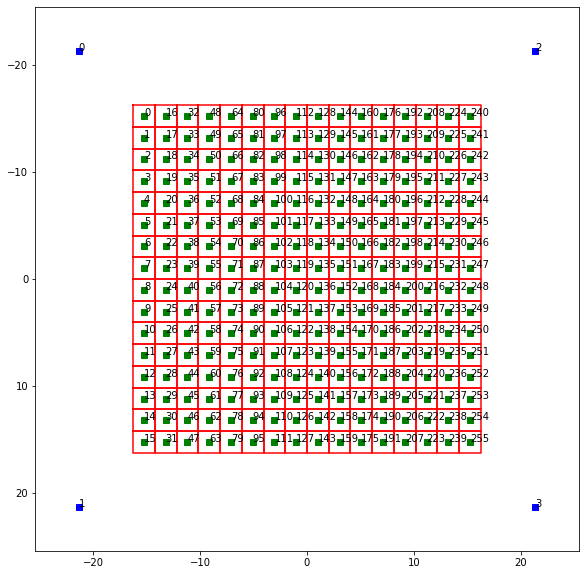

In [16]:
cb_geom.plot()

In [17]:
file_model = Path('models/dot_vision_checker.pth')
detector = DotVisionCheckerDLDetector(file_model)

In [18]:
refiner = OpenCVCheckerRefiner(hw_min=5, hw_max=15, cutoff_it=20, cutoff_norm=1e-3)

In [19]:
files_img = list(Path('data/dot_vision_checker').glob('*.png'))
files_img

[PosixPath('data/dot_vision_checker/SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2.png'),
 PosixPath('data/dot_vision_checker/SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:19-438636_CAM_3_FRAMEID_0_COUNTER_1.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1.png')]

In [20]:
def _parse_name(name_img):
    match = re.match(r'''SERIAL_(?P<serial>.*)_
                         DATETIME_(?P<date>.*)_
                         CAM_(?P<cam>.*)_
                         FRAMEID_(?P<frameid>.*)_
                         COUNTER_(?P<counter>.*).png''', 
                     name_img, 
                     re.VERBOSE)
    return match.groupdict()

In [21]:
imgs = []
for file_img in files_img:
    dict_group = _parse_name(file_img.name)
    img = File16bitImg(file_img)
    img.idx_cam = int(dict_group['cam'])-1
    img.idx_cb  = int(dict_group['counter'])-1
    imgs.append(img)

In [22]:
for img in imgs: print(f'{img.name} - cam: {img.idx_cam} - cb: {img.idx_cb}')

SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2 - cam: 1 - cb: 1
SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1 - cam: 0 - cb: 0
SERIAL_16276942_DATETIME_2019-06-07-00:38:19-438636_CAM_3_FRAMEID_0_COUNTER_1 - cam: 2 - cb: 0
SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2 - cam: 2 - cb: 1
SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1 - cam: 1 - cb: 0


In [23]:
cams, distorts, rigids_cb, rigids_cam, debug = calib_multi(imgs, cb_geom, detector, refiner)

Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1...
Refining single parameters...
 - Iteration: 000 - Norm:    0.00483 - Loss:    5.36058
 - Iteration: 001 - Norm:    0.15146 - Loss:    3.71881
 - Iteration: 002 - Norm:    3.92902 - Loss:    3.49835
 - Iteration: 003 - Norm:    7.61183 - Loss:    3.26027
 - Iteration: 004 - Norm:   53.26645 - Loss:    1.69542
 - Iteration: 005 - Norm:    0.00000 - Loss:    1.69542
Refining control points for: SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2...
Refining control points for: SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1...
Refining single parameters...
 - Iteration: 000 - Norm:    0.04100 - Loss:  145.66077
 - Iteration: 001 - Norm:    0.13687 - Loss:   83.93632
 - Iteration: 002 - Norm:    0.84322 - Loss:    3.98970
 - Iteration: 003 - Norm:    0.27753 - Loss:    3.59056
 - Iteration: 004 - Norm:    6.15321 - Loss:    3.

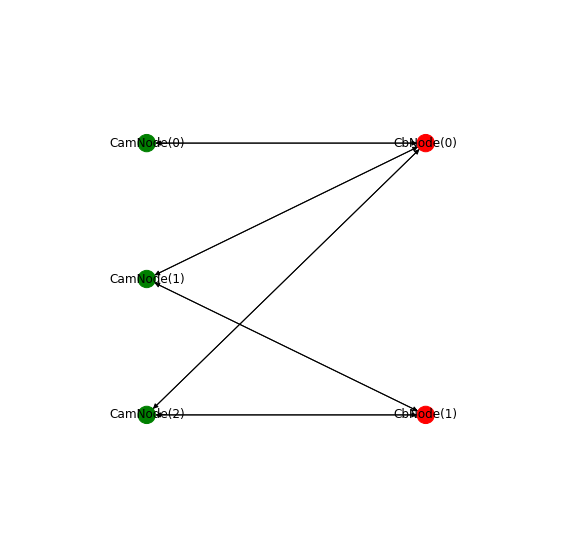

In [24]:
draw_bipartite(*debug[2:])

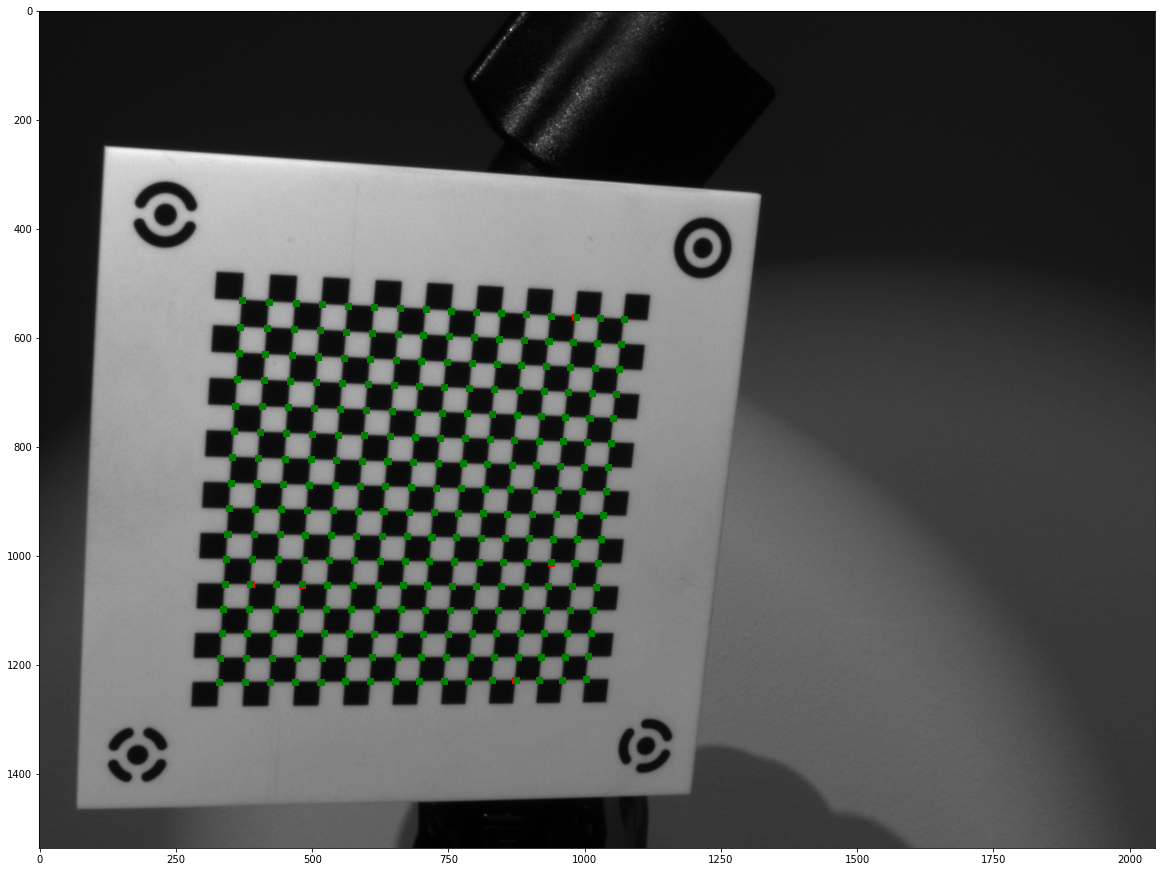

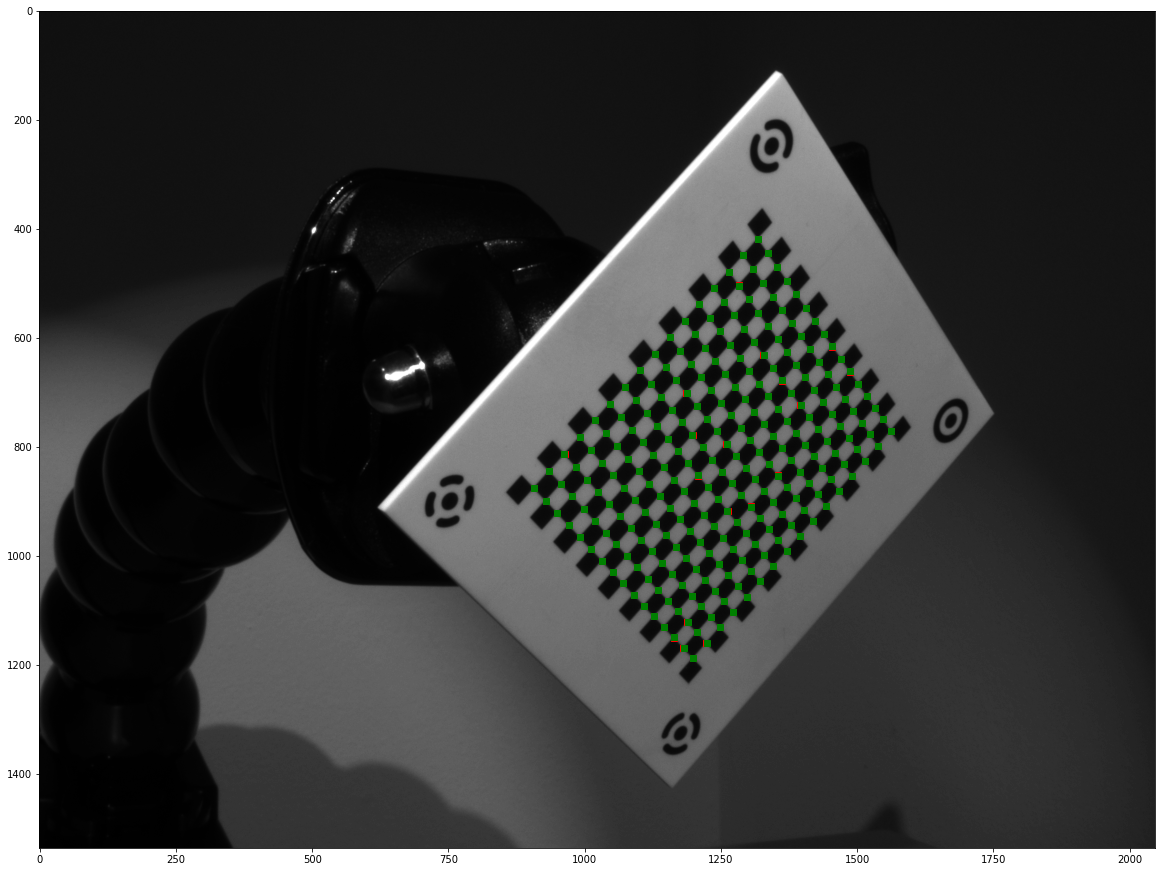

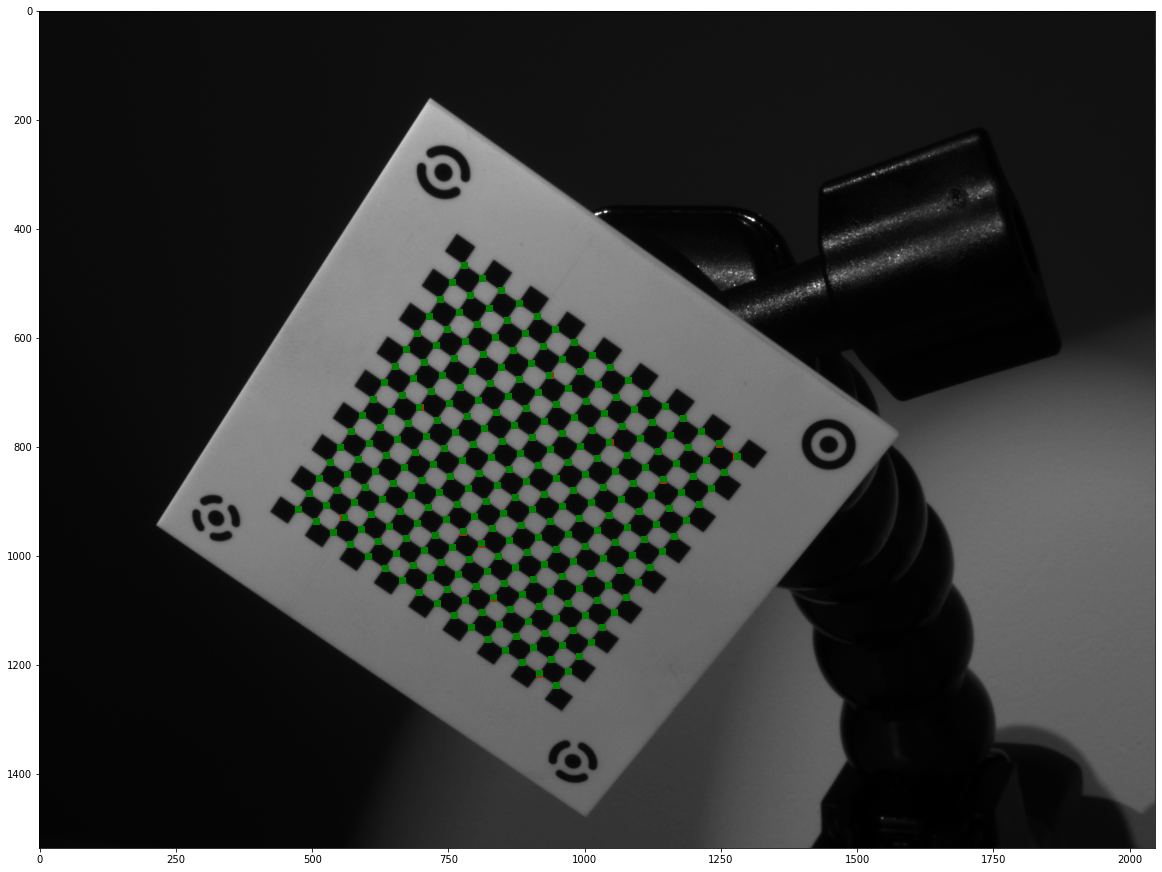

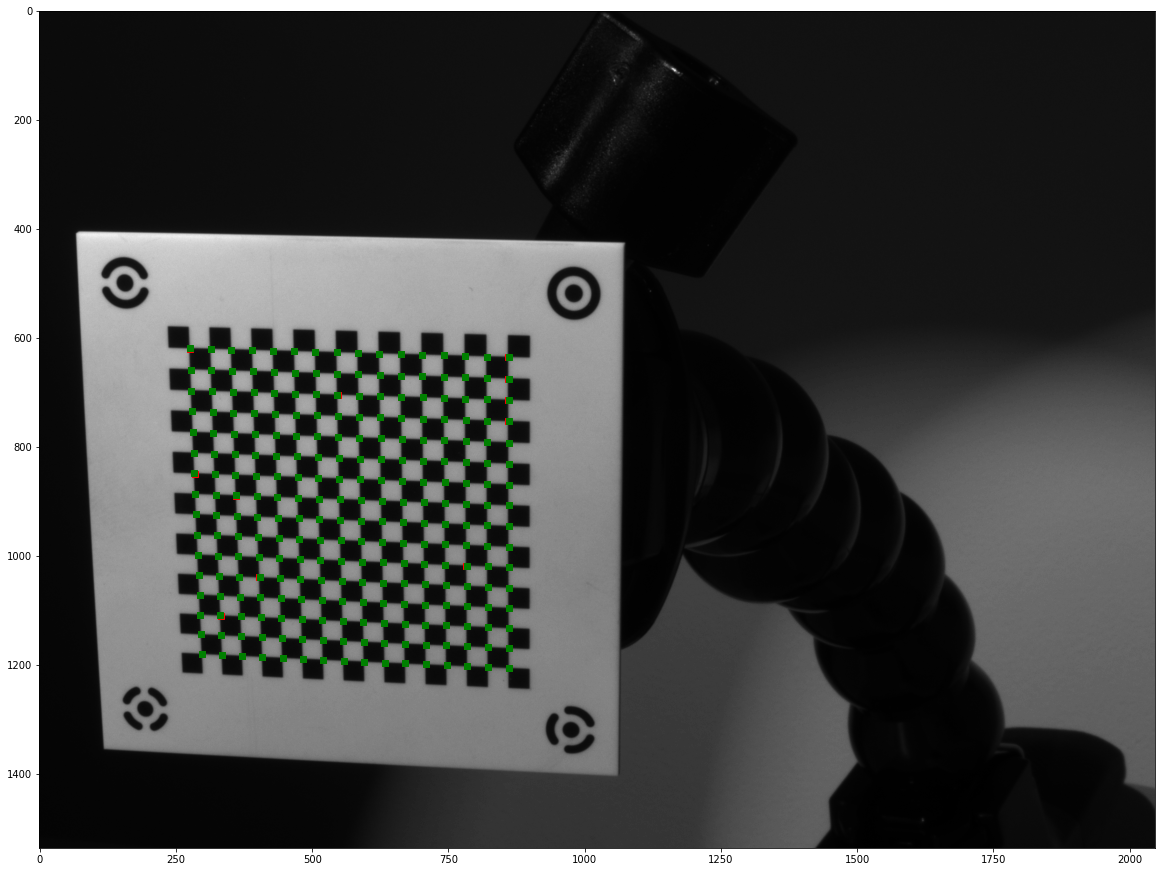

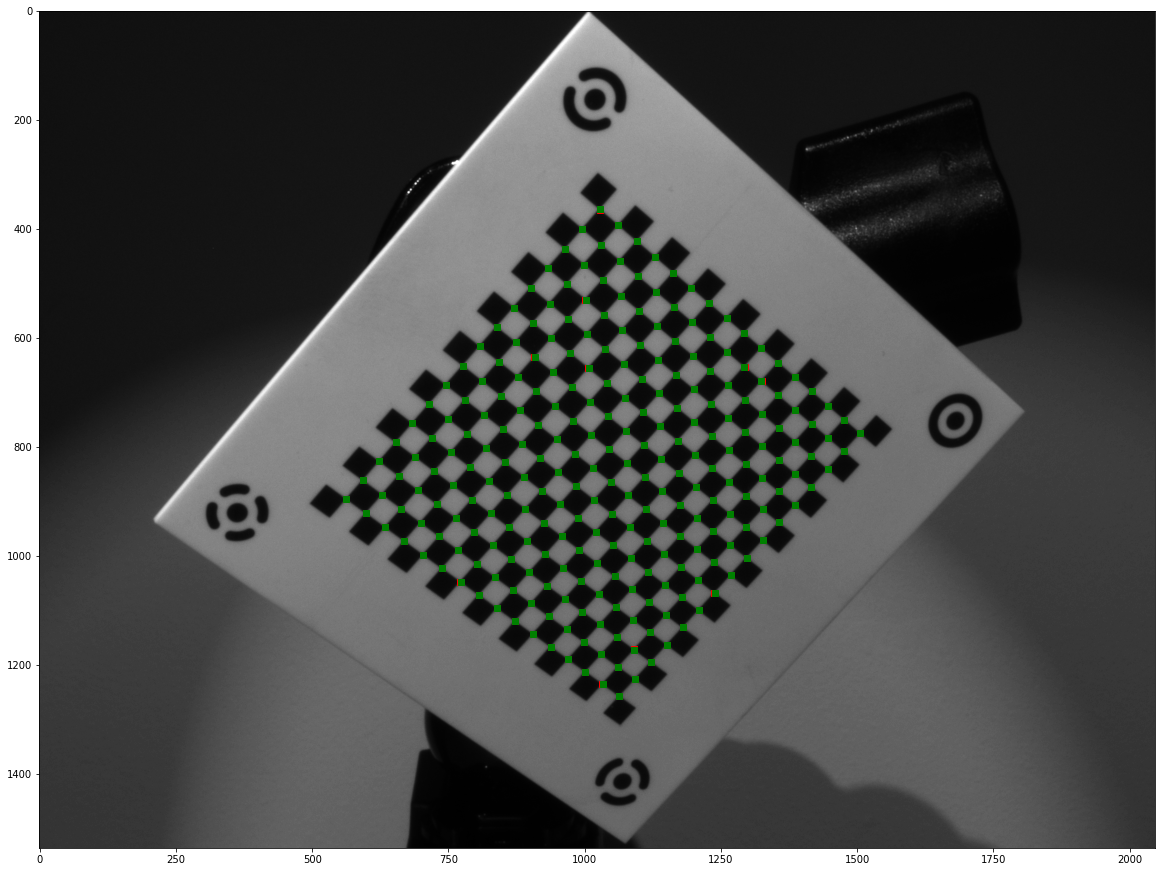

In [25]:
for idx, img in enumerate(imgs):
    plt.figure(idx, figsize=(20,20))
    plt.imshow(img.array_gs, cmap='gray')
    plt.plot(debug[0][idx][:,0], debug[0][idx][:,1], 'rs')
    plt.plot(debug[1][idx][:,0], debug[1][idx][:,1], 'gs')

(-0.25, 0.25)

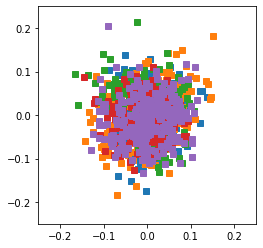

In [26]:
for p1, p2 in zip(debug[0], debug[1]):
    res = (p1-p2)
    plt.plot(res[:,0], res[:,1], 's')
plt.gca().set_aspect(1)
plt.gca().set_xlim(-0.25, 0.25)
plt.gca().set_ylim(-0.25, 0.25)

In [27]:
torch.save([cams, distorts, rigids_cb, rigids_cam, cb_geom], 'data/dot_vision_checker/calib.pth')

# Build

In [28]:
!nbdev_build_lib

Converted README.ipynb.
Converted calib.ipynb.
Converted cb_geom.ipynb.
Converted control_refine.ipynb.
Converted fiducial_detect.ipynb.
Converted image.ipynb.
Converted modules.ipynb.
Converted plot.ipynb.
Converted utils.ipynb.
